In [1]:
import os
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import cell2location
import scvi
import scipy
from matplotlib import rcParams
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120, frameon=False, figsize=(3, 3), facecolor='white')
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
from cell2location.utils.filtering import filter_genes
from cell2location.models import RegressionModel
from cell2location.plt import plot_spatial
from cell2location import run_colocation

/home/yqcj/miniconda3/envs/cell2loc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results_folder = '/home/featurize/YS_station/ZJH_KRAS/Workdir/4.Cell2loaction'
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [4]:
name="/home/featurize/YS_station/ZJH_KRAS/Datadir/scRNA/ZJH_KRAS_all_"
raw=sc.read(name+"merge_raw.h5ad")
raw

AnnData object with n_obs × n_vars = 162669 × 16358
    obs: 'predicted_doublets', 'batch', 'sample'

In [15]:
adata= sc.read_h5ad(name+"afternewtype.h5ad")
adata

AnnData object with n_obs × n_vars = 134900 × 5000
    obs: 'predicted_doublets', 'batch', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'leiden', 'KRAS', 'Celltype', 'Newtype', 'Maintype'
    var: 'n_cells', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'KRAS_colors', 'Maintype_colors', 'Newtype_colors', 'batch_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [16]:
adata_ref=raw[adata.obs_names]
adata_ref

View of AnnData object with n_obs × n_vars = 134900 × 16358
    obs: 'predicted_doublets', 'batch', 'sample'

In [18]:
adata_ref.obs["Celltype"]=adata.obs["Newtype"]

/tmp/ipykernel_11616/3903473645.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ref.obs["Celltype"]=adata.obs["Newtype"]


In [19]:
# find mitochondria-encoded (MT) genes
adata_ref.var["MT_gene"]=[gene.startswith("MT-") for gene in adata_ref.var.index]

In [20]:
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_ref.obsm['MT'] = adata_ref[:, adata_ref.var['MT_gene'].values].X.toarray()
adata_ref = adata_ref[:, ~adata_ref.var['MT_gene'].values]
adata_ref

View of AnnData object with n_obs × n_vars = 134900 × 16345
    obs: 'predicted_doublets', 'batch', 'sample', 'Celltype'
    var: 'MT_gene'
    obsm: 'MT'

/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/cell2location/utils/filtering.py:26: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = np.array((adata.X > 0).sum(0)).flatten()


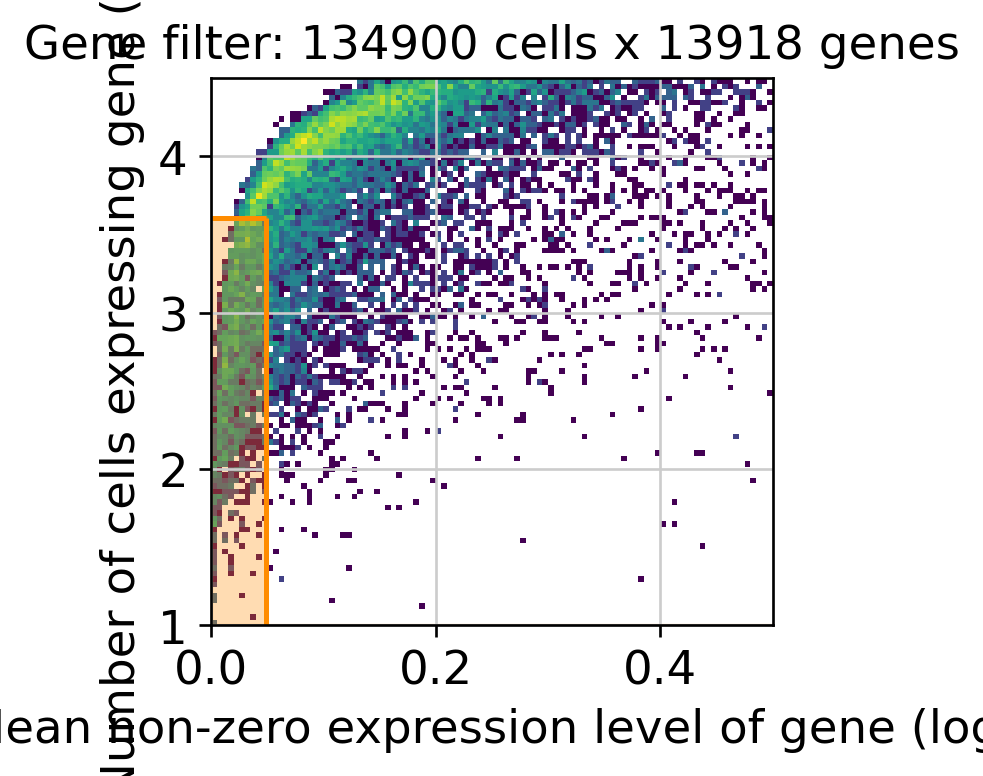

In [21]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
# filter the object
adata_ref = adata_ref[:, selected].copy()
#默认参数cell_count_cutoff=5，cell_percentage_cutoff2=0.03，nonz_mean_cutoff=1.12比较合适，但是用户可以增加截断值以排除更多的基因。
#为了保留罕见细胞类型的标记基因，作者建议将cell_count_cutoff设置为较低的值，例如5，但是cell_percentage_cutoff2和nonz_mean_cutoff可以适当增加，可以控制在8,000至16,000个基因

In [22]:
#变稀疏矩阵，减少内存
adata_ref.X=scipy.sparse.csr_matrix(adata_ref.X)

In [23]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                         batch_key='sample', # 10X reaction / sample / batch
                         labels_key='Celltype' # cell type, covariate used for constructing signatures
                         #categorical_covariate_keys=['Method'] # multiplicative technical effects (platform, 3' vs 5', donor effect)
                       )
#['Method'] = ['10X_3prime', '10X_5prime', 'Smartseq', ...]

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [24]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)
# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.6.post2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'Celltype',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   54   │
│         n_cells          │ 134900 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   33   │
│          n_vars          │ 13918  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ GSM4904236 │          0          │
│                     │ GSM4904239 │          1          │
│                     │ GSM4904245 │          2          │
│                     │ GSM6886537 │          3          │
│                     │ GSM6886539 │          4          │
│                     │ GSM7290763 │          5          │
│                     │ GSM7290769 │          6          │
│                     │ GSM7290772 │          7          │
│                     │ GSM7290774 │          8          │
│                     │ GSM7290777 │          9          │
│                     │  KUL01_T   │         10          │
│                     │  KUL19_T   │         11          │
│                     │  KUL21_T   │         12          │
│                     │  KUL28_T   │         13          │
│                     │  KUL30_T   │         14          │
│                     │  KUL31_T   │         15          │
│                     │  SMC01_T   │         16          │
│                     │  SMC02_T   │         17          │
│                     │  SMC03_T   │         18          │
│                     │  SMC04_T   │         19          │
│                     │  SMC05_T   │         20          │
│                     │  SMC06_T   │         21          │
│                     │  SMC07_T   │         22          │
│                     │  SMC08_T   │         23          │
│                     │  SMC09_T   │         24          │
│                     │  SMC10_T   │         25          │
│                     │  SMC11_T   │         26          │
│                     │  SMC14_T   │         27          │
│                     │  SMC15_T   │         28          │
│                     │  SMC16_T   │         29          │
│                     │  SMC17_T   │         30          │
│                     │  SMC18_T   │         31          │
│                     │  SMC19_T   │         32          │
│                     │  SMC20_T   │         33          │
│                     │  SMC21_T   │         34          │
│                     │  SMC22_T   │         35          │
│                     │  SMC23_T   │         36          │
│                     │  SMC24_T   │         37          │
│                     │  SMC25_T   │         38          │
│                     │   T_CAC1   │         39          │
│                     │   T_CAC2   │         40          │
│                     │   T_CAC3   │         41          │
│                     │   T_CAC4   │         42          │
│                     │   T_CAC5   │         43          │
│                     │   T_CAC6   │         44          │
│                     │   T_CAC7   │         45          │
│                     │   T_CAC8   │         46          │
│                     │   T_CAC9   │         47          │
│                     │  T_CAC10   │         48          │
│                     │  T_CAC11   │         49          │
│                     │  T_CAC12   │         50          │
│                     │  T_CAC13   │         51          │
│                     │  T_CAC14   │         52          │
│                     │  T_CAC16   │         53          │
└─────────────────────┴────────────┴─────────────────────┘

                       labels State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Celltype'] │      CD4_Tcm      │          0          │
│                       │      CD4_Tem      │          1          │
│                       │       Treg        │          2          │
│                       │      CD8_Tem      │          3          │
│                       │      CD8_Tex      │          4          │
│                       │     T_Prolif      │          5          │
│                       │     NK_cells      │          6          │
│                       │        DCs        │          7          │
│                       │    Macro_C1QC     │          8          │
│                       │  Macro_TNFRSF17   │          9          │
│                       │    Mono_MALAT1    │         10          │
│                       │    Mono_S100A8    │         11          │
│                       │    Fib_CTHRC1     │         12          │
│                       │    Fib_CXCL14     │         13          │
│                       │      Fib_GAL      │         14          │
│                       │     Fib_IGF1      │         15          │
│                       │     Fib_MMP1      │         16          │
│                       │     Fib_PRKG1     │         17          │
│                       │     Pericytes     │         18          │
│                       │      Epi_01       │         19          │
│                       │      Epi_02       │         20          │
│                       │      Epi_03       │         21          │
│                       │      Epi_04       │         22          │
│                       │      Epi_05       │         23          │
│                       │      Epi_06       │         24          │
│                       │      Epi_07       │         25          │
│                       │      Epi_08       │         26          │
│                       │      Epi_09       │         27          │
│                       │      Epi_10       │         28          │
│                       │ Endothelial_cells │         29          │
│                       │      B_cells      │         30          │
│                       │    Mast_cells     │         31          │
│                       │   Plasma_cells    │         32          │
└───────────────────────┴───────────────────┴─────────────────────┘

In [25]:
adata_ref.var['SYMBOL'] = adata_ref.var.index

In [26]:
#Train NB model
#max_epochs不能小于250
#mod.train(max_epochs=250, accelerator="cpu", train_size=1)
mod.train(max_epochs=500,batch_size=2500, accelerator="gpu", train_size=1)
#这一步运行时间极长

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_

Epoch 500/500: 100%|██████████| 500/500 [56:35<00:00,  7.59s/it, v_num=1, elbo_train=8.62e+8]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [56:35<00:00,  6.79s/it, v_num=1, elbo_train=8.62e+8]


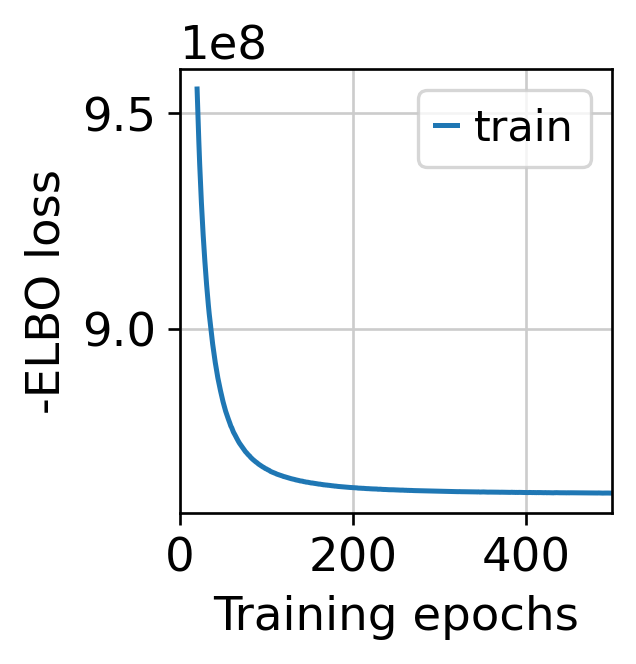

In [27]:
#Determine if the model needs more training
mod.plot_history(20)

In [28]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
)

Sampling global variables, sample: 100%|██████████| 999/999 [00:07<00:00, 131.47it/s]


In [ ]:
#使用分位数方法（更快，但不适合计算均值和标准差）直接计算后验分布的分位数（例如，第5%、50%、95%分位数）。更快、更节省内存，但无法获得后验分布的均值和标准差
# adata_ref = mod.export_posterior(
#     adata_ref, use_quantiles=True,
#     add_to_varm=["q05","q50", "q95", "q0001"],  # 注意这里用 add_to_varm
#     sample_kwargs={'batch_size': 2500}
# )

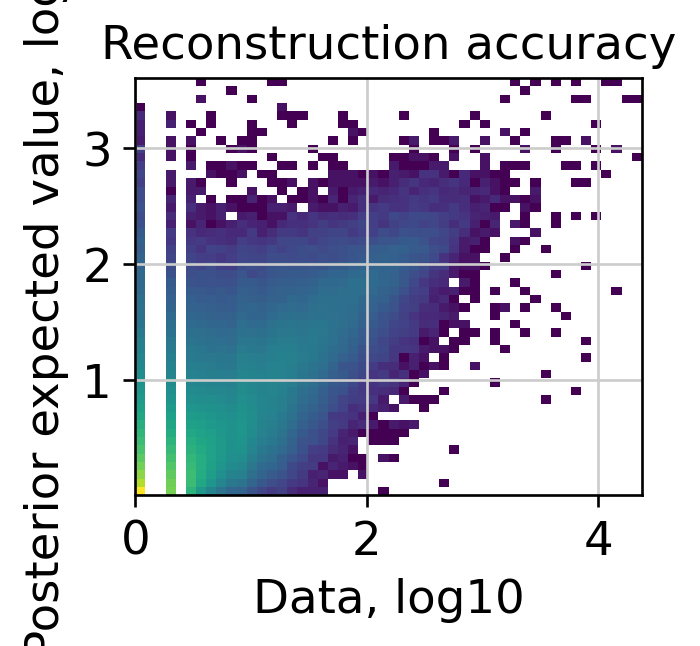

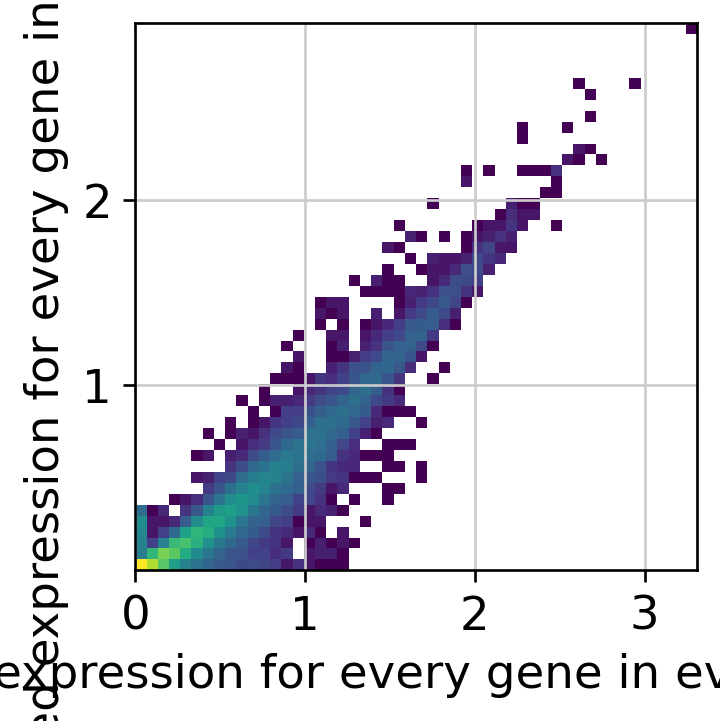

In [29]:
#Save model
mod.save(f'{ref_run_name}',overwrite=True)
#Save anndata object with results
adata_ref.write(f"{ref_run_name}/sc.h5ad")
#Examine QC plots 图形呈对角线状说明质量较好
mod.plot_QC()

In [30]:
#For spatial mapping we just need the estimated expression of every gene in every cell type
#负二项回归模型的所有参数都被导出到参考 anndata 对象中，但是对于空间映射，我们只需要每个基因在每个细胞类型中的估计表达。在这里，我们从标准输出中提取这些信息：
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' for i in adata_ref.uns['mod']['factor_names']]].copy()

inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5,0:15]

,CD4_Tcm,CD4_Tem,Treg,CD8_Tem,CD8_Tex,T_Prolif,NK_cells,DCs,Macro_C1QC,Macro_TNFRSF17,Mono_MALAT1,Mono_S100A8,Fib_CTHRC1,Fib_CXCL14,Fib_GAL
SAMD11,0.000224,0.000077,0.000135,0.000078,0.000086,0.004848,0.001135,0.001545,0.000217,0.000617,0.000210,0.000158,0.226071,0.366024,0.038234
NOC2L,0.034992,0.026382,0.037817,0.030077,0.030864,0.673083,0.031245,0.075203,0.057058,0.018088,0.004047,0.013708,0.131830,0.144326,0.039675
PLEKHN1,0.001745,0.003319,0.007387,0.000829,0.006191,0.044791,0.005843,0.005447,0.002147,0.002227,0.000530,0.000886,0.004367,0.006397,0.004568
HES4,0.014564,0.025043,0.034693,0.002347,0.009464,0.432233,0.036103,0.299841,0.255716,0.005441,0.095330,0.124999,0.438211,0.373345,0.065976
ISG15,0.188866,0.210740,0.424888,0.208324,0.284091,1.205042,0.227952,1.443241,1.343749,0.094572,0.111966,0.817320,1.597454,1.751514,0.428059


In [31]:
inf_aver.columns

Index(['CD4_Tcm', 'CD4_Tem', 'Treg', 'CD8_Tem', 'CD8_Tex', 'T_Prolif',
       'NK_cells', 'DCs', 'Macro_C1QC', 'Macro_TNFRSF17', 'Mono_MALAT1',
       'Mono_S100A8', 'Fib_CTHRC1', 'Fib_CXCL14', 'Fib_GAL', 'Fib_IGF1',
       'Fib_MMP1', 'Fib_PRKG1', 'Pericytes', 'Epi_01', 'Epi_02', 'Epi_03',
       'Epi_04', 'Epi_05', 'Epi_06', 'Epi_07', 'Epi_08', 'Epi_09', 'Epi_10',
       'Endothelial_cells', 'B_cells', 'Mast_cells', 'Plasma_cells'],
      dtype='object')

In [32]:
inf_aver.shape

(13918, 33)

In [33]:
#后续Spatial Mapping仅需要inf_aver文件作为输入，在此保存和读取
inf_aver.to_csv(f'{ref_run_name}/inf_aver.csv',index=True)
inf_aver = pd.read_csv(f'{ref_run_name}/inf_aver.csv',index_col=0)

In [34]:
inf_aver = pd.read_csv(f'{ref_run_name}/inf_aver.csv',index_col=0)

## 多切片空间转录cell2location

In [5]:
#存储10X Visium测序文件的文件夹路径
sp_data_folder = '/home/featurize/YS_station/ZJH_KRAS/Datadir/Spatial/'

In [6]:
sample_names = [i for i in os.listdir(sp_data_folder)]

In [7]:
sample_names

['CRC_WT_D1', 'CRC_MUT_B1', 'CRC_MUT_A1', 'CRC_WT_C1']

In [10]:
#将每个样本和对应的分组先进行匹配，方便后续定义
#group_dict = {'CTR-161':'HD','CTR-179':'HD','CTR-180':'HD','CYG-1495':'NAFL','CYL-1501':'NASH','HJD-1478':'NASH','HJJ-1480':'NASH','LCQ-1481':'NASH','LLF-1492':'NAFL','LP-1494':'NASH','LSH-1498':'NAFL','XRP-1493':'NAFL','YM-171':'NAFL','ZHT-1475':'NASH','ZLM-1497':'NAFL','ZTH-1479':'NAFL'}
group_dict = {'CRC_WT_D1':"WT", 'CRC_MUT_B1':"WT", 'CRC_MUT_A1':"MUT", 'CRC_WT_C1':"MUT"}
sample_names = [i for i in os.listdir(sp_data_folder)]

In [11]:
#Read one Visium file and add minimum metadadta and QC metrics to adata.obs. Note: var_names is ENSEMBL ID as it should be, you can always plot with sc.pl.scatter(gene_symbols='SYMBOL')
#group_dict是当你的空转样本有分组时，你可以先做一个dict sample_name：group_information 然后在读数据时就给定义上去，不是必要的参数可以删掉
def read_and_qc(sample_name,group_dict,path=sp_data_folder,force_filter=True):
  adata = sc.read_visium(path + str(sample_name) + '/',count_file='filtered_feature_bc_matrix.h5',load_images=True)
  adata.obs['sample'] = sample_name
  adata.obs['group'] = group_dict.get(sample_name) #导入分组信息
  adata.var['SYMBOL'] = adata.var_names
  
  #just in case there are non-unique ENSEMBL IDs
  adata.var_names_make_unique()
  
  #Calculate QC metrics
  adata.var['mt'] = adata.var_names.str.startswith('MT-')
  sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'],inplace=True,percent_top=None,log1p=False)
  adata.var['rps'] = [gene.startswith('RPS') for gene in adata.var['SYMBOL']]
  adata.var['mrp'] = [gene.startswith('MRP') for gene in adata.var['SYMBOL']]
  adata.var['rpl'] = [gene.startswith('RPL') for gene in adata.var['SYMBOL']]
  
  #Add sample name to obs names
  adata.obs['sample'] = [str(i) for i in adata.obs['sample']]
  adata.obs_names = adata.obs['sample'] + '_' + adata.obs_names
  adata.obs.index.name = 'spot_id'
  adata.var['duplicated'] = adata.var['SYMBOL'].duplicated(keep = 'first')
  adata = adata[:, ~adata.var['duplicated'].values]
  
  #replacing adata.uns['spatial'] key name
  #一开始的key可能不太合适，那么我们用sample_name重新替代一下
  file = list(adata.uns['spatial'].keys())[0]
  adata.uns['spatial'][sample_name] = adata.uns['spatial'][file].copy()
  if file!=sample_name:
    del adata.uns['spatial'][file]
  print(adata.uns['spatial'].keys())
  
  if force_filter:
    #first filter: mt and rb genes remove MT/RPS/RPL/MRP genes for spatial mapping (keeping their counts in the object)
    adata.obsm['mt'] = adata[:, adata.var['mt'].values|adata.var['rps'].values|adata.var['mrp'].values|adata.var['rpl'].values].X.toarray()
    adata = adata[:, ~(adata.var['mt'].values|adata.var['rps'].values|adata.var['mrp'].values|adata.var['rpl'].values)]
    #Second filter: genes expressed in less than 3 spots
    adata = adata[:, adata.var['n_cells_by_counts'].values >= 3]
    #Third filter: spots with no information (less than 300 genes and 600 UMIs)
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata = adata[(adata.obs['n_genes_by_counts'].values > 300) & (adata.obs['total_counts'].values > 600),:]
  return adata
  
#合并多个10X Visium测序样本为一个anndata对象
slides = []
for i in sample_names:
  adata = read_and_qc(sample_name = i , path = sp_data_folder, group_dict = group_dict, force_filter= True)
  slides.append(adata)
  del adata
adata_vis = slides[0].concatenate(slides[1:],batch_key='sample',uns_merge='unique',batch_categories=sample_names,index_unique=None)

/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


dict_keys(['CRC_WT_D1'])


/tmp/ipykernel_11616/611470908.py:36: ImplicitModificationWarning: Setting element `.obsm['mt']` of view, initializing view as actual.
  adata.obsm['mt'] = adata[:, adata.var['mt'].values|adata.var['rps'].values|adata.var['mrp'].values|adata.var['rpl'].values].X.toarray()
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


dict_keys(['CRC_MUT_B1'])


/tmp/ipykernel_11616/611470908.py:36: ImplicitModificationWarning: Setting element `.obsm['mt']` of view, initializing view as actual.
  adata.obsm['mt'] = adata[:, adata.var['mt'].values|adata.var['rps'].values|adata.var['mrp'].values|adata.var['rpl'].values].X.toarray()
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


dict_keys(['CRC_MUT_A1'])


/tmp/ipykernel_11616/611470908.py:36: ImplicitModificationWarning: Setting element `.obsm['mt']` of view, initializing view as actual.
  adata.obsm['mt'] = adata[:, adata.var['mt'].values|adata.var['rps'].values|adata.var['mrp'].values|adata.var['rpl'].values].X.toarray()
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


dict_keys(['CRC_WT_C1'])


/tmp/ipykernel_11616/611470908.py:36: ImplicitModificationWarning: Setting element `.obsm['mt']` of view, initializing view as actual.
  adata.obsm['mt'] = adata[:, adata.var['mt'].values|adata.var['rps'].values|adata.var['mrp'].values|adata.var['rpl'].values].X.toarray()
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/tmp/ipykernel_11616/611470908.py:51: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_vis = slides[0].concatenate(slides[1:],batch_key='sample',uns_merge='unique',batch_categories=sample_names,index_unique=None)


In [12]:
adata_vis

AnnData object with n_obs × n_vars = 8113 × 15758
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'group', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'mt', 'rps', 'mrp', 'rpl', 'duplicated', 'n_cells_by_counts-CRC_MUT_A1', 'mean_counts-CRC_MUT_A1', 'pct_dropout_by_counts-CRC_MUT_A1', 'total_counts-CRC_MUT_A1', 'log1p_mean_counts-CRC_MUT_A1', 'log1p_total_counts-CRC_MUT_A1', 'n_cells_by_counts-CRC_MUT_B1', 'mean_counts-CRC_MUT_B1', 'pct_dropout_by_counts-CRC_MUT_B1', 'total_counts-CRC_MUT_B1', 'log1p_mean_counts-CRC_MUT_B1', 'log1p_total_counts-CRC_MUT_B1', 'n_cells_by_counts-CRC_WT_C1', 'mean_counts-CRC_WT_C1', 'pct_dropout_by_counts-CRC_WT_C1', 'total_counts-CRC_WT_C1', 'log1p_mean_counts-CRC_WT_C1', 'log1p_total_counts-

In [13]:
adata_vis.obs['sample'].value_counts()

sample
CRC_WT_D1     2459
CRC_WT_C1     2064
CRC_MUT_A1    1953
CRC_MUT_B1    1637
Name: count, dtype: int64

In [35]:
#Find shared genes and prepare anndata. Subset both anndata and reference signatures
inf_aver = pd.read_csv(f'{ref_run_name}/inf_aver.csv',index_col=0)
intersect = np.intersect1d(adata_vis.var_names,inf_aver.index)
adata_vis = adata_vis[:,intersect].copy()
inf_aver = inf_aver.loc[intersect,:].copy()

#prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis,batch_key='sample')

#create and train the model
mod = cell2location.models.Cell2location(adata_vis, cell_state_df=inf_aver,N_cells_per_location=30,detection_alpha=20)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.6.post2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   4   │
│         n_cells          │ 8113  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 12453 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ CRC_WT_D1  │          0          │
│                     │ CRC_MUT_B1 │          1          │
│                     │ CRC_MUT_A1 │          2          │
│                     │ CRC_WT_C1  │          3          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/environment/miniconda3/envs/cell2loc/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 30000/30000: 100%|██████████| 30000/30000 [52:34<00:00,  9.53it/s, v_num=1, elbo_train=5.12e+7]  

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [52:34<00:00,  9.51it/s, v_num=1, elbo_train=5.12e+7]


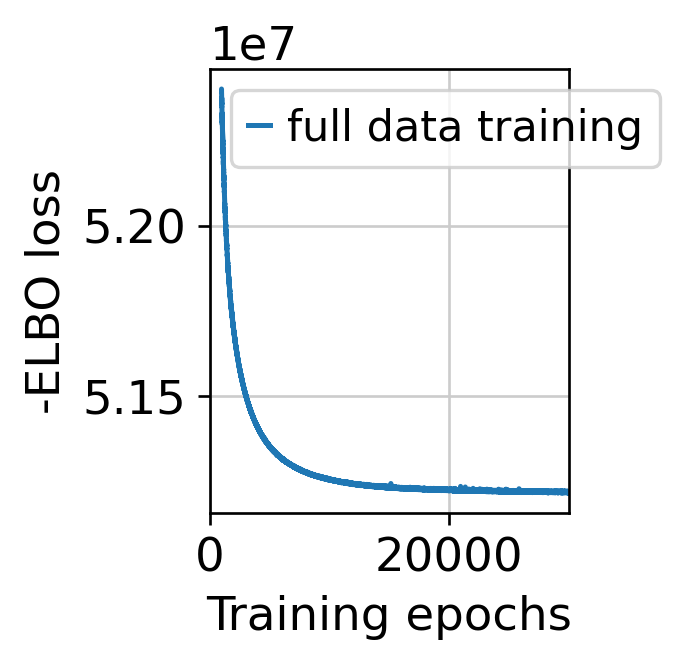

In [36]:
#Training cell2location
mod.train(max_epochs=30000,batch_size=None,train_size=1)
#plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])
#这一步运行时间长

Sampling global variables, sample: 100%|██████████| 999/999 [00:17<00:00, 55.78it/s]


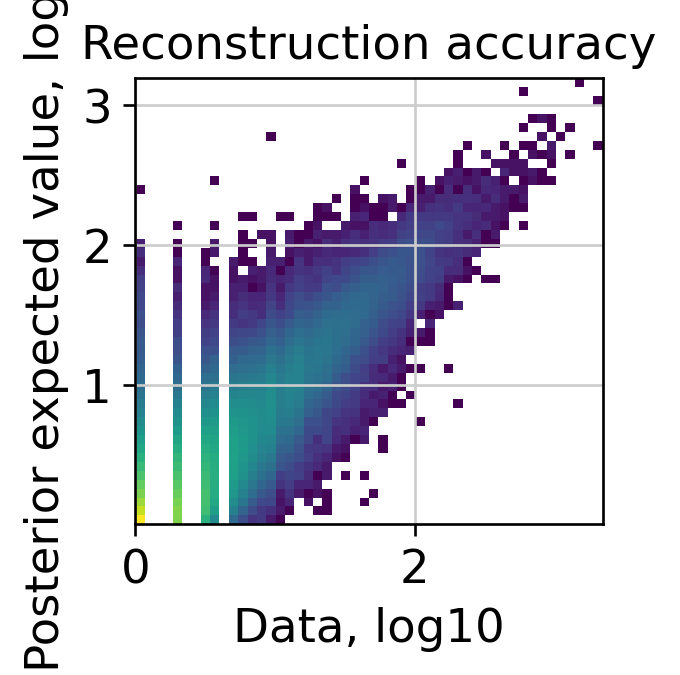

In [37]:
# 导出细胞丰度的后验分布估计结果
# sample_kwargs 用于设置采样参数：num_samples 是采样次数，batch_size 是批处理大小，与数据观测数一致
adata_vis = mod.export_posterior(adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs})
# 将后验分布中 5% 分位数的结果（q05_cell_abundance_w_sf）添加到 adata.obs 中
# 表示“至少存在的细胞丰度数量”，可以作为保守估计结果，用于绘图和解释
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
# 保存模型到指定路径，路径由变量 run_name 定义
# overwrite=True 表示允许覆盖同名文件
mod.save(f"{run_name}", overwrite=True)

# （可选）加载保存的模型（如果需要重新载入模型和数据，可以取消注释以下代码）
# adata_vis = sc.read_h5ad('/data/project/liziyu/NAFLD/results/ST/cell2location/cell2location_map/adata_c2l.h5ad')
# mod = cell2location.models.Cell2location.load(f'{run_name}', adata_vis)
# 保存 AnnData 对象到 .h5ad 文件中，路径由变量 run_name 定义
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)

# 绘制质量控制（QC）图，用于评估模型的性能（如残差分布、参数收敛性等）
mod.plot_QC()


In [2]:
adata_vis = sc.read_h5ad("/mnt/g/E-disk/ZJH_KRAS/Workdir/4.Cell2location/cell2location_map/sp.h5ad")
adata_vis

AnnData object with n_obs × n_vars = 8113 × 12453
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'group', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', '_indices', '_scvi_batch', '_scvi_labels', 'CD4_Tcm', 'CD4_Tem', 'Treg', 'CD8_Tem', 'CD8_Tex', 'T_Prolif', 'NK_cells', 'DCs', 'Macro_C1QC', 'Macro_TNFRSF17', 'Mono_MALAT1', 'Mono_S100A8', 'Fib_CTHRC1', 'Fib_CXCL14', 'Fib_GAL', 'Fib_IGF1', 'Fib_MMP1', 'Fib_PRKG1', 'Pericytes', 'Epi_01', 'Epi_02', 'Epi_03', 'Epi_04', 'Epi_05', 'Epi_06', 'Epi_07', 'Epi_08', 'Epi_09', 'Epi_10', 'Endothelial_cells', 'B_cells', 'Mast_cells', 'Plasma_cells'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'mt', 'rps', 'mrp', 'rpl', 'duplicated', 'n_cells_by_counts-CRC_MUT_A1', 'mean_counts-CRC_MUT_A1', 'pct_dropout_by_counts-CRC_MUT_A1', 'total_